# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

### А ещё есть консультация 2023 года :)

https://www.youtube.com/watch?v=oCwEmKW3bYg

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом. На Windows, скорее всего, вас ждет немало проблем :(

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

Отдельная благодарность А. Абрамову за написание assert для проверки функций и В. Гилязову за поясняющую картинку.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:

!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

!unzip -q data.zip

--2024-11-22 16:03:38--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2024-11-22 16:03:39--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.78M  --.-KB/s    in 0.1s    

2024-11-22 16:03:39 (158 MB/s) - ‘data.zip’ saved [17592727/17592727]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [3]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        # то есть res выглядит как [xmin, ymin, xmax, ymax, class]
        # всё в int!
        # Для корректной работы клеточек ниже требуется конкретная последовательность координат
        # См. доку https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
        # Нас интересует pascal_voc формат, далее применяется он.
        bndbox = member.find('bndbox')
        xmin = bndbox.find('xmin').text
        ymin = bndbox.find('ymin').text
        xmax = bndbox.find('xmax').text
        ymax = bndbox.find('ymax').text
        class1 = class_dict[member.find('name').text]
        res =  (xmin, ymin, xmax, ymax, class1)

        bboxes.append(res)

    return bboxes

In [4]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        # Нужно обладая файлнеймом подгрузить картинку и бибоксы, функцию для подгрузки бибоксов вы дописали выше :)
        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        # transform будут объявлены ниже за вас
        # Но библиотека привередлива к формату данных на входе, внимательно прочтите прошлую клеточку
        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        lenfn = len(self.filenames)
        return lenfn

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Вот тут мы говорим что хотим pascal_voc
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [6]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [7]:
from torchvision import transforms

In [8]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv
        Inv_Transform = transforms.Compose([transforms.Normalize(mean = [0., 0., 0.], std = [1/0.229, 1/0.224, 1/0.225]), transforms.Normalize(mean = [-0.485, -0.456, -0.406],
                                                                    std = [1., 1., 1.]),])
        tensor = Inv_Transform(images[i])
        # Вот тут покажите картинку после отката нормализации
        ax.imshow(tensor.permute((1, 2, 0)))

        for bbox in bboxes[i]:
        # Вот тут нарисуйте бибоксы
          xmin, ymin, xmax, ymax, class1 = bbox
          name = train_ds.class_dict_inv[class1]
          rect = Rectangle((xmin, ymin), width = xmax - xmin, height = ymax - ymin, linewidth = 1, edgecolor = 'red', facecolor = 'none')
          ax.add_patch(rect)
          ax.text(x = xmin, y = ymin + 1.5, s = name, color = 'red')


    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://i.imgur.com/V5TUT26.png)

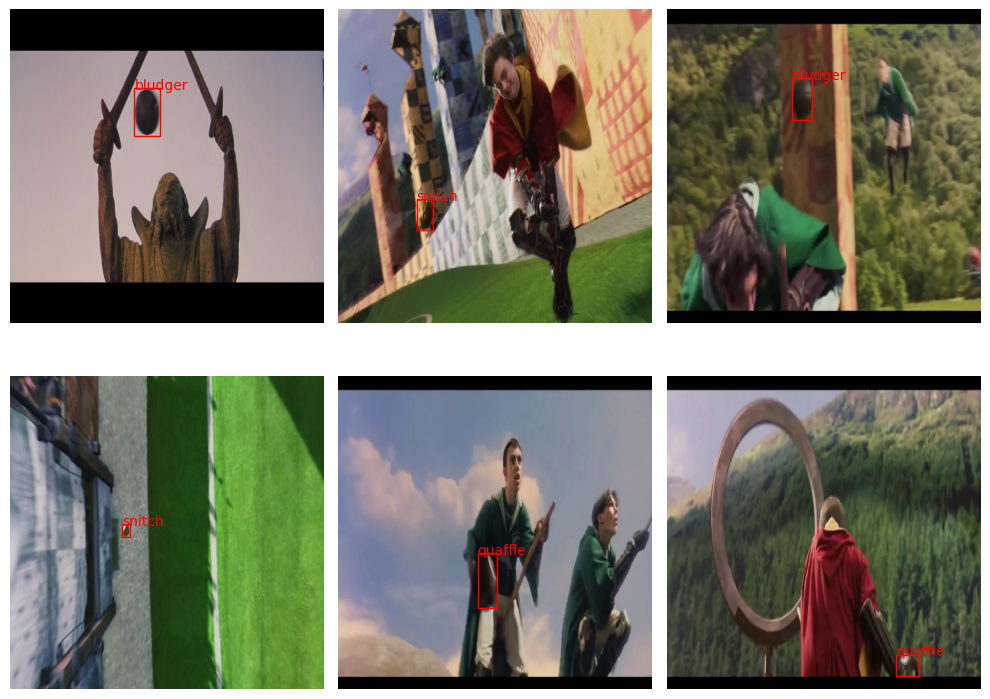

In [9]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и вернуть тензор размера Bx6x16x16. Первая размерность - это количество примеров в батче. Вторая -- "каналы", суть которых написана чуть ниже. Далее идут две пространственные размерности, это сетка 16 на 16. Зафиксируем порядок координат как (y, x) для этой сетки 16 на 16. Это значит, что в target идут ```cy_idx, cx_idx``` в таком порядке, см. код.

В шести "каналах" у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "гиперпиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

### Пояснительная картинка.

Она обладает некоторым уровнем абстракции, чёрных например должно быть 512, а зелёная должна захватывать 32 маленькие черные. Но может будет понятнее :)

![image](https://i.imgur.com/13YVxAd.jpeg)

In [10]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell = downsample # TODO размер клетки по X в пикс
        y_cell = downsample # TODO размер клетки по Y в пикс

        # ширина и высота бибокса могут превышать размеры гиперпикселя
        # поэтому их мы нормируем на полноценные 512
        w_box = (xmax - xmin) / w # TODO ширина бокса отнормированная на размер изначальной картинки
        h_box = (ymax - ymin) / h # TODO высота бокса отнормированная на размер изначальной картинки

        # Посчитайте координаты центра и сдвиги
        cx = (xmax + xmin) / 2 # TODO (координаты центра в исходных координатах)
        cy = (ymax + ymin) / 2 # TODO
        cx_idx = (cx // x_cell).long() # TODO (посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx = (cy // y_cell).long() # TODO

        cx_box = (cx - cx_idx * x_cell) / x_cell # TODO (посчитайте сдивиги относительно cx_idx)
        cy_box = (cy - cy_idx * y_cell) / y_cell # TODO

        # cy_idx, потом cx_idx
        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [11]:
def test_collate_fn() -> None:
    target1 = [ 100, 200, 200, 300, 2 ] # xmin, ymin, xmax, ymax, class
    target2_1 = [ 0, 250, 200, 300, 0 ] # xmin, ymin, xmax, ymax, class
    target2_2 = [ 0, 100, 100, 300, 1 ] # xmin, ymin, xmax, ymax, class

    result = collate_fn([
        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target1 ] },
        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target2_1, target2_2 ] }
    ])

    # Проверяем размерности
    assert result['image'].shape == (2, 3, 512, 512)
    assert result['target'].shape == (2, 6, 16, 16)

    # Проверяем значения клеточек, в которые попали ббоксы
    assert np.allclose(result['target'][0, :, 7, 4], torch.tensor([ 22 / 32, 26 / 32, 100 / 512, 100 / 512, 1, 2 ]))
    assert np.allclose(result['target'][1, :, 8, 3], torch.tensor([ 4 / 32, 19 / 32, 200 / 512, 50 / 512, 1, 0 ]))
    assert np.allclose(result['target'][1, :, 6, 1], torch.tensor([ 18 / 32, 8 / 32, 100 / 512, 200 / 512, 1, 1 ]))

    # Проверяем, что все остальные клеточки содержат нули
    result['target'][0, :, 7, 4] = result['target'][1, :, 8, 3] = result['target'][1, :, 6, 1] = torch.zeros(6)
    assert np.allclose(result['target'], 0)

test_collate_fn()

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

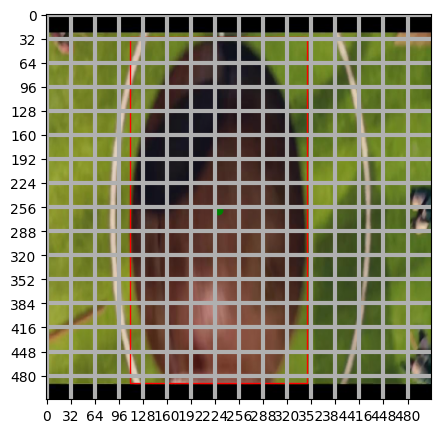

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx6x16x16. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [13]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    bboxes_pred = [[] for x in range(b)]
    for pic in range(b):
      for i in range(h):
        for j in range(w):
          if pred[pic, 4, i, j] > threshold:
            cx_box, cy_box, box_w, box_h = pred[pic, :4, i, j]
            w_i = box_w * img_w
            h_i = box_h * img_h
            cx = (cx_box * upsample) + (j * upsample)
            cy = (cy_box * upsample) + (i * upsample)
            xmax = cx + (w_i / 2)
            xmin = cx - (w_i / 2)
            ymax = cy + (h_i / 2)
            ymin = cy - (h_i / 2)
            if c > 6:
              class_pred =  torch.argmax(pred[pic, 5:, i, j])
            else:
              class_pred = pred[pic, 5, i, j]
            bboxes_pred[pic].append([xmin.item(), ymin.item(), xmax.item(), ymax.item(), class_pred.item()])
    return bboxes_pred

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [14]:
def test_decode_predictions() -> None:
    # Применяем collate_fn к некоторым данным
    target1 = [ [ 100, 200, 200, 300, 2 ] ]
    target2 = [ [ 0, 250, 200, 300, 0 ], [ 0, 100, 100, 300, 1 ] ]
    result = collate_fn([
        { 'image': torch.rand((3, 512, 512)), 'bboxes': target1 },
        { 'image': torch.rand((3, 512, 512)), 'bboxes': target2 }
    ])

    target = result['target']
    assert target.shape == (2, 6, 16, 16)
    # В таком виде target соответствует поиску одного класса - 6-ой канал.
    # Добавим еще 2 канала, чтобы проверить работу функции для нескольких классов
    target = torch.cat([ target, torch.zeros(2, 2, 16, 16) ], dim = 1) # Добавляем два канала
    assert target.shape == (2, 8, 16, 16) # Теперь их стало 8

    target[0, 5:, 7, 4] = torch.tensor([ 0.5, 0.6, 0.9 ]) # Это должен быть класс 2
    target[1, 5:, 8, 3] = torch.tensor([ 0.9, 0.6, 0.5 ]) # Это должен быть класс 0
    target[1, 5:, 6, 1] = torch.tensor([ 0.6, 0.9, 0.5 ]) # Это должен быть класс 1

    # Считаем результат
    actual = decode_prediction(target)
    print('Actual:  ', actual)

    # Порядок ббоксов для target2 может меняться в зависимости от вашей реализации и это не ошибка.
    # Скорее всего, он будет такой. Но если ассерт не проходит, попробуйте поменять их местами.
    expected = [ target1, [ target2[1], target2[0] ] ]
    # expected = [ target1, [ target2[0], target2[1] ] ] # <-- такой ответ тоже правильный.
    print('Expected:', expected)

    # Сравниваем
    assert actual == expected

test_decode_predictions()

Actual:   [[[100.0, 200.0, 200.0, 300.0, 2]], [[0.0, 100.0, 100.0, 300.0, 1], [0.0, 250.0, 200.0, 300.0, 0]]]
Expected: [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]


## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [15]:
import json

file = open('data/class_dict', 'r')
class_dict = json.load(file)
len(list(class_dict.keys()))

3

In [16]:
C =  3

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.layer1 = nn.Sequential(*list(model.children())[:8])
        self.layer2 = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 5+C, kernel_size = 3, padding = 1),
        )


    def forward(self, img):
        x = self.layer1(img)
        newx = self.layer2(x)
        newx = torch.sigmoid(newx)
        return newx

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. Подумайте как зависит индексация от параметра C и используйте его.

In [17]:
def get_mask(pred, target):
  b, _, w, h = target.shape
  mask_target_1 = []
  mask_target_0 = []
  mask_pred_1 = []
  mask_pred_0 = []
  for pic in range(b):
    for i in range(w):
      for j in range(h):
        if target[pic, 4, i, j] == 1:
          mask_target_1.append(target[pic, :, i, j])
          mask_pred_1.append(pred[pic, :, i, j])
        else:
          mask_target_0.append(target[pic, :, i, j])
          mask_pred_0.append(pred[pic, :, i, j])

  return torch.stack(mask_target_1), torch.stack(mask_pred_1), torch.stack(mask_target_0), torch.stack(mask_pred_0)

In [21]:
def special_loss(pred, target, C=C):
    b, _, w, h = target.shape
    masks = get_mask(pred, target)
    detected_target = masks[0]
    detected_pred = masks[1]
    undetected_target = masks[2]
    undetected_pred = masks[3]
    localization_loss = nn.MSELoss(reduction='sum')(detected_pred[:, :2], detected_target[:, :2])
    box_loss = nn.MSELoss(reduction='sum')(torch.sqrt(detected_pred[:, 2:4]), torch.sqrt(detected_target[:, 2:4]))
    classification_loss = nn.CrossEntropyLoss(reduction='sum')(detected_pred[:, 5:(5 + C)], detected_target[:, 5].long())
    confidence_loss_det = nn.BCELoss(reduction='sum')(detected_pred[:, 4], detected_target[:, 4])
    confidence_loss_nondet = nn.BCELoss(reduction='sum')(undetected_pred[:, 4], undetected_target[:, 4])
    confidence_loss = confidence_loss_det + confidence_loss_nondet

    return localization_loss + box_loss + classification_loss + confidence_loss

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [19]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 20 # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        img = batch['image'].to(device)
        targ = batch['target'].to(device)
        preds = model(img)
        loss = special_loss(preds, targ)
        loss.backward()
        opt.step()
        opt.zero_grad()
        epoch_losses.append(loss.item())


    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0 done; Train loss 572.278;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 done; Train loss 123.020;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 done; Train loss 71.604;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 done; Train loss 49.179;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 done; Train loss 39.334;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 done; Train loss 35.601;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 done; Train loss 28.998;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 done; Train loss 25.260;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 done; Train loss 20.412;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 done; Train loss 15.410;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 done; Train loss 12.947;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 done; Train loss 11.642;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 done; Train loss 10.711;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 done; Train loss 9.978;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 done; Train loss 9.418;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 done; Train loss 8.949;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 done; Train loss 8.634;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 done; Train loss 8.562;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 done; Train loss 8.588;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 done; Train loss 8.211;


Запустим обученный детектор на тестовых изображениях:

In [23]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [24]:
# Нужно сделать предсказание и переложить результат на cpu

with torch.no_grad():
  img = batch['image'].to(device)
  pred = model(img)
  pred = decode_prediction(preds, threshold=0.1)

pred_cpu = [p.to('cpu') if isinstance(p, torch.Tensor) else p for p in pred]

In [35]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1

def visualize2(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv
        Inv_Transform = transforms.Compose([transforms.Normalize(mean = [0., 0., 0.], std = [1/0.229, 1/0.224, 1/0.225]), transforms.Normalize(mean = [-0.485, -0.456, -0.406],
                                                                    std = [1., 1., 1.]),])
        tensor = Inv_Transform(images[i])
        # Вот тут покажите картинку после отката нормализации
        ax.imshow(tensor.permute((1, 2, 0)))

        if i < len(bboxes):
          for bbox in bboxes[i]:
            xmin, ymin, xmax, ymax, class1 = bbox[0], bbox[1], bbox[2], bbox[3], bbox[4]
            name = train_ds.class_dict_inv[class1]
            rect = Rectangle((xmin, ymin), width = xmax - xmin, height = ymax - ymin, linewidth = 1, edgecolor = 'red', facecolor = 'none')
            ax.add_patch(rect)
            ax.text(x = xmin, y = ymin + 1.5, s = name, color = 'red')

    fig.tight_layout()
    plt.show()

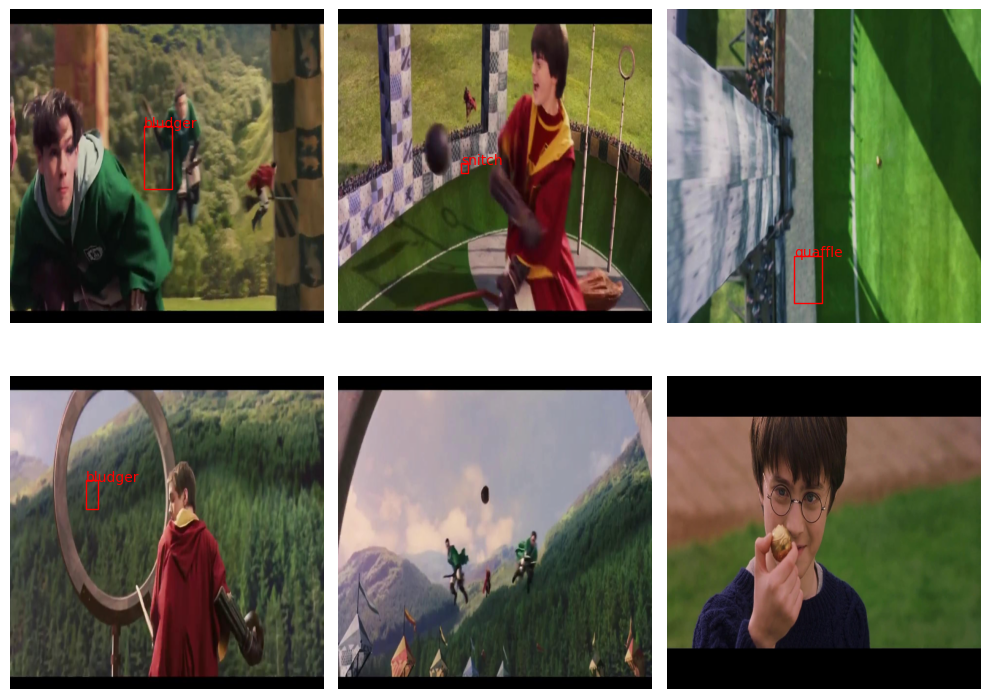

In [36]:
visualize2(img.cpu(), pred_cpu)

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO 11 от ultralytics.

In [37]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 27.6 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [38]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO 11. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

Использовать сторонние инструменты нельзя, нужно переложить своими руками.

In [95]:
def annotation2txt(bboxes, w_im, h_im):
    x_min, y_min, x_max, y_max, class1 = bboxes
    xcent = float((xmax + xmin) / (2 * w_im))
    ycent = float((ymax + ymin) / (2 * h_im))
    h_bbox = float((xmax - xmin) / w_im)
    w_bbox = float((ymax - ymin) / h_im)


    return [str(class1), str(xcent), str(ycent), str(h_bbox), str(w_bbox)]

In [96]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\t".join(annotation2txt(result[1][0], w_im, h_im))) #Поменял на табуляцию и сразу убрал скобки

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\t".join(annotation2txt(result[1][0], w_im, h_im))) #Поменял на табуляцию и сразу убрал скобки

In [66]:
result = train_ds.__get_raw_item__(i)
result[1][0]

('761', '272', '916', '435', 2)

In [53]:
list(set(class_dict.keys()))

['bludger', 'quaffle', 'snitch']

In [98]:
# Собираем YAML

nc = 3 # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = ['bludger', 'quaffle', 'snitch'] # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO 11 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель можно взять обученную.

Подсказка: подумайте зачем вам data.yaml и что такое yolo11n.yaml (не стесняйтесь гуглить)

Если у вас лосс NaN или Windows, то есть несколько полезных ссылок (покрывают не все существующие проблемы, но может поможет вам):

https://github.com/ultralytics/ultralytics/issues/1149

https://github.com/ultralytics/yolov5/issues/6907

https://stackoverflow.com/questions/75178762/i-got-nan-for-all-losses-while-training-yolov8-model

In [113]:
import ultralytics

model = ultralytics.YOLO('yolo11n.yaml')
results = model.train(data='data.yaml', epochs=200, imgsz=512, device='cuda')

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.yaml, data=data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_

train: Scanning /content/train/labels.cache... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]


Plotting labels to runs/detect/train12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train12
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      1.95G      3.745      4.769      4.241         35        512: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         29         29    0.00364      0.919    0.00372   0.000372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      1.94G      3.671      4.634      4.186         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         29         29     0.0013      0.586    0.00163   0.000404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      1.95G      3.505      4.528      4.043         34        512: 100%|██████████| 16/16 [00:03<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         29         29    0.00135      0.619    0.00154   0.000252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      1.95G      3.175      4.417      3.869         37        512: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         29         29    0.00189      0.667    0.00217    0.00045



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      1.95G      2.836      4.218       3.58         27        512: 100%|██████████| 16/16 [00:03<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         29         29   0.000486      0.333    0.00106   0.000607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      1.94G      2.526       4.13      3.325         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         29         29    0.00179      0.633     0.0025    0.00131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      1.94G      2.416      3.963      3.078         33        512: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         29         29    0.00177      0.633    0.00379    0.00144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      1.94G      2.332      3.822      2.844         29        512: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


                   all         29         29    0.00234      0.695    0.00957    0.00274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      1.94G      2.328      3.751      2.801         35        512: 100%|██████████| 16/16 [00:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         29         29       0.68     0.0556     0.0512     0.0309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      1.94G      2.201      3.768      2.703         31        512: 100%|██████████| 16/16 [00:04<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         29         29    0.00277      0.788    0.00911    0.00315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      1.94G      2.184      3.565       2.68         31        512: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         29         29      0.532      0.305      0.198      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      1.94G       2.21      3.494      2.686         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         29         29    0.00379      0.952     0.0343     0.0194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      1.94G       2.14      3.453      2.596         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


                   all         29         29     0.0121      0.886      0.147     0.0573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      1.94G      2.162      3.347       2.64         27        512: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         29         29      0.695      0.167       0.11     0.0618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      1.94G      2.085      3.276      2.551         31        512: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

                   all         29         29      0.721       0.25       0.18     0.0971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      1.94G      2.107      3.315      2.541         27        512: 100%|██████████| 16/16 [00:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all         29         29     0.0473      0.183     0.0784     0.0359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      1.94G      2.055      3.143        2.5         33        512: 100%|██████████| 16/16 [00:04<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         29         29     0.0544      0.716      0.108      0.043



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      1.94G      2.014      3.081      2.453         26        512: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

                   all         29         29      0.082      0.166     0.0929     0.0417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      1.94G      2.028      3.078      2.431         31        512: 100%|██████████| 16/16 [00:03<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


                   all         29         29      0.195      0.487      0.187       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      1.94G      1.943      3.037      2.374         31        512: 100%|██████████| 16/16 [00:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         29         29      0.147      0.594      0.295       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      1.94G      1.943      2.967      2.364         33        512: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         29         29     0.0131      0.967      0.116      0.062



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      1.94G       1.92      2.899      2.316         31        512: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         29         29      0.399      0.133      0.302      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      1.94G      1.857      2.823      2.326         24        512: 100%|██████████| 16/16 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         29         29      0.342      0.331       0.35      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      1.94G      1.844       2.81      2.301         35        512: 100%|██████████| 16/16 [00:03<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         29         29      0.559      0.196      0.271      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      1.94G      1.795      2.779       2.28         32        512: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         29         29        0.5      0.304      0.302      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      1.94G      1.787      2.799      2.254         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


                   all         29         29      0.452     0.0944      0.235      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      1.94G      1.765      2.739      2.227         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         29         29      0.408      0.334      0.321      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      1.94G      1.702      2.658      2.149         23        512: 100%|██████████| 16/16 [00:06<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         29         29     0.0955      0.311      0.209      0.098



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      1.94G      1.708      2.677      2.183         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         29         29      0.299      0.616      0.406      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      1.94G      1.747      2.609       2.19         25        512: 100%|██████████| 16/16 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

                   all         29         29      0.672      0.339      0.475      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      1.94G      1.671       2.56      2.108         34        512: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         29         29      0.477      0.361      0.273      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      1.94G      1.654      2.551      2.146         38        512: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         29         29      0.506      0.456      0.479      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      1.94G      1.675      2.566      2.127         34        512: 100%|██████████| 16/16 [00:03<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


                   all         29         29      0.444      0.332      0.371      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      1.94G       1.56      2.569      2.055         22        512: 100%|██████████| 16/16 [00:03<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         29         29      0.257      0.403      0.284      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      1.94G      1.589      2.499      2.048         26        512: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         29         29      0.279      0.451      0.295      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      1.94G      1.529      2.416      2.004         29        512: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         29         29      0.421      0.383      0.306      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      1.94G      1.565      2.423      2.002         29        512: 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         29         29      0.476      0.383      0.383      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      1.94G      1.537      2.394      1.985         31        512: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


                   all         29         29      0.425      0.488      0.402      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      1.94G      1.503      2.416      1.977         25        512: 100%|██████████| 16/16 [00:03<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

                   all         29         29      0.266      0.568      0.411      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      1.94G      1.463      2.292      1.934         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


                   all         29         29      0.292       0.63      0.382      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      1.94G      1.431      2.296      1.882         33        512: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         29         29       0.35      0.627      0.378      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      1.94G      1.426      2.317      1.937         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


                   all         29         29      0.415      0.613      0.505      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      1.94G      1.371      2.222       1.87         29        512: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         29         29      0.354       0.45      0.439      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      1.94G      1.366      2.216      1.876         36        512: 100%|██████████| 16/16 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         29         29      0.457      0.561      0.503      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      1.94G      1.389      2.203      1.891         28        512: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         29         29      0.254      0.389      0.425      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      1.94G      1.376      2.195      1.862         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         29         29      0.394      0.602      0.457      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      1.94G      1.376      2.199      1.854         32        512: 100%|██████████| 16/16 [00:03<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


                   all         29         29      0.317       0.61      0.446      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      1.94G      1.334      2.154      1.842         27        512: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         29         29      0.553      0.604      0.571      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      1.94G       1.29      2.098      1.755         27        512: 100%|██████████| 16/16 [00:03<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


                   all         29         29      0.356      0.763      0.546      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      1.94G      1.374      2.094      1.829         34        512: 100%|██████████| 16/16 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

                   all         29         29       0.37      0.609      0.564       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      1.94G      1.367      2.084      1.864         32        512: 100%|██████████| 16/16 [00:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         29         29      0.451      0.633      0.498      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      1.94G      1.302      2.127      1.797         28        512: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

                   all         29         29        0.7      0.549      0.604      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      1.94G      1.255      2.032      1.736         34        512: 100%|██████████| 16/16 [00:03<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         29         29      0.571      0.435      0.556      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      1.94G      1.317      1.999      1.805         27        512: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         29         29      0.525       0.59      0.546      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      1.94G      1.314      2.043      1.768         31        512: 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

                   all         29         29      0.443      0.584      0.584      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      1.94G      1.247       1.99      1.767         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         29         29      0.606      0.676      0.646      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      1.94G      1.246      1.985      1.734         34        512: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


                   all         29         29      0.335      0.489      0.356      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      1.94G      1.214      1.947      1.689         23        512: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         29         29      0.459      0.702      0.585      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      1.94G       1.19      1.953      1.683         30        512: 100%|██████████| 16/16 [00:04<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


                   all         29         29      0.611      0.699      0.629      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      1.94G      1.251      1.975      1.715         24        512: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         29         29      0.547      0.785      0.692       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      1.94G      1.219      1.987      1.705         22        512: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         29         29       0.58      0.728      0.726      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      1.94G      1.199      1.912      1.675         28        512: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

                   all         29         29      0.549      0.719      0.638       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      1.94G      1.212      1.855       1.68         31        512: 100%|██████████| 16/16 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


                   all         29         29      0.535      0.635      0.618      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      1.94G      1.251      1.888      1.698         25        512: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         29         29      0.424      0.808      0.615      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      1.94G      1.167      1.812      1.662         22        512: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         29         29      0.368      0.665      0.628      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      1.94G      1.161      1.838      1.645         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


                   all         29         29      0.542       0.72      0.677      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      1.94G      1.126      1.705      1.613         27        512: 100%|██████████| 16/16 [00:03<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         29         29       0.67       0.73      0.702      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      1.94G      1.119      1.733      1.599         28        512: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         29         29      0.519      0.755      0.692      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      1.94G      1.093      1.726      1.594         32        512: 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

                   all         29         29      0.576      0.803      0.674      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      1.94G      1.142      1.767      1.625         33        512: 100%|██████████| 16/16 [00:03<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         29         29      0.464      0.885      0.709      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      1.94G      1.107      1.664      1.584         32        512: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         29         29      0.634      0.844      0.717      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      1.94G      1.112      1.692      1.587         29        512: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         29         29      0.618      0.797      0.661       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      1.94G      1.097      1.702      1.582         29        512: 100%|██████████| 16/16 [00:03<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         29         29      0.503      0.674      0.692      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      1.94G      1.134      1.705      1.616         27        512: 100%|██████████| 16/16 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         29         29      0.459      0.808      0.637       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      1.94G      1.032      1.599      1.552         31        512: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         29         29      0.653      0.691      0.723      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      1.94G      1.103       1.69      1.582         30        512: 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         29         29      0.547       0.76      0.648      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      1.94G      1.091       1.67       1.58         33        512: 100%|██████████| 16/16 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         29         29      0.436      0.788      0.598      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      1.94G      1.146      1.683      1.592         31        512: 100%|██████████| 16/16 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         29         29      0.561       0.76      0.669      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      1.94G      1.078      1.729      1.541         28        512: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         29         29      0.526      0.855      0.653      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      1.94G      1.125      1.748      1.584         25        512: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         29         29      0.622        0.8      0.675      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      1.94G      1.131       1.78      1.589         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         29         29      0.665       0.84      0.685      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      1.94G      1.126      1.656      1.562         38        512: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         29         29      0.553      0.851      0.674      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      1.94G      1.031      1.685      1.498         30        512: 100%|██████████| 16/16 [00:06<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         29         29      0.577      0.721      0.739      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      1.94G     0.9968      1.598      1.524         26        512: 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         29         29      0.692      0.737      0.726      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      1.94G      1.021      1.556      1.522         27        512: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         29         29      0.635      0.911      0.695      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      1.94G       1.08        1.6      1.562         29        512: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         29         29      0.546      0.773      0.721      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      1.94G      1.042       1.54      1.529         32        512: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

                   all         29         29      0.451      0.731       0.64      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      1.94G     0.9836      1.517      1.489         35        512: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


                   all         29         29      0.497      0.808      0.635      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      1.94G      1.044      1.555      1.535         37        512: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         29         29      0.603      0.763      0.703      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      1.94G      1.001      1.535      1.496         24        512: 100%|██████████| 16/16 [00:03<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


                   all         29         29      0.694      0.826        0.7      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      1.94G       1.03      1.533      1.529         29        512: 100%|██████████| 16/16 [00:03<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         29         29      0.594      0.873      0.718       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      1.94G     0.9859      1.506      1.437         40        512: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         29         29      0.612      0.889       0.74      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      1.94G     0.9651      1.494      1.469         28        512: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         29         29      0.552      0.863        0.7      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      1.94G      1.014      1.482      1.505         31        512: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


                   all         29         29      0.624      0.863      0.687      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      1.94G      1.012      1.456      1.496         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         29         29       0.63      0.911      0.719       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      1.94G     0.9881      1.518      1.468         30        512: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         29         29      0.698      0.891       0.77      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      1.94G      1.029      1.491      1.505         21        512: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         29         29      0.641      0.911      0.729      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      1.94G     0.9584      1.363      1.441         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


                   all         29         29      0.637      0.863      0.776      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      1.94G      1.002      1.433      1.486         22        512: 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         29         29      0.653      0.853      0.729      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      1.94G     0.9417       1.43       1.43         34        512: 100%|██████████| 16/16 [00:04<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         29         29      0.709      0.925      0.774      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      1.94G     0.9448      1.394      1.434         35        512: 100%|██████████| 16/16 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         29         29      0.724      0.764      0.785       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      1.94G      1.008      1.399      1.499         28        512: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         29         29      0.539      0.637      0.632      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      1.94G     0.9291      1.371      1.428         30        512: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


                   all         29         29      0.635      0.816      0.759      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      1.94G     0.9242      1.354      1.425         25        512: 100%|██████████| 16/16 [00:03<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         29         29      0.699      0.825      0.755      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      1.94G      0.972      1.427      1.445         31        512: 100%|██████████| 16/16 [00:03<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

                   all         29         29      0.673      0.836       0.77      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      1.94G     0.9002       1.35      1.395         24        512: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         29         29       0.65      0.788      0.738      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      1.94G      0.918      1.354      1.406         23        512: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


                   all         29         29      0.712      0.823      0.758      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      1.94G     0.9245       1.39      1.429         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

                   all         29         29      0.711      0.779      0.751      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      1.94G     0.9837      1.412      1.456         36        512: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         29         29      0.609      0.542      0.662      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      1.94G     0.9275      1.384      1.413         28        512: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         29         29      0.555      0.784       0.74      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      1.94G     0.8516      1.325      1.351         24        512: 100%|██████████| 16/16 [00:03<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         29         29      0.648      0.833      0.776      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      1.94G     0.8726      1.294      1.374         36        512: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         29         29       0.61      0.836      0.782      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      1.94G     0.8448      1.224      1.331         28        512: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         29         29      0.646      0.815      0.797      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      1.94G     0.9159       1.36      1.397         31        512: 100%|██████████| 16/16 [00:03<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         29         29      0.649      0.863       0.76      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      1.94G     0.9007      1.303       1.37         33        512: 100%|██████████| 16/16 [00:03<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         29         29      0.598      0.897      0.789      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      1.94G     0.8907       1.24      1.392         34        512: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         29         29      0.616      0.891      0.723      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      1.94G        0.9      1.356      1.387         30        512: 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         29         29      0.674      0.691      0.768      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      1.94G     0.8761       1.32      1.384         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         29         29      0.695      0.816      0.763       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      1.94G     0.8707      1.246      1.368         32        512: 100%|██████████| 16/16 [00:03<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         29         29      0.649      0.848      0.759      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      1.94G     0.8479      1.262      1.357         23        512: 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         29         29      0.782      0.788      0.815      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      1.94G      0.877      1.379      1.392         22        512: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all         29         29      0.755      0.891      0.835      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      1.94G     0.8628      1.293      1.361         34        512: 100%|██████████| 16/16 [00:03<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         29         29      0.642      0.808      0.774      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      1.94G     0.9314      1.325      1.424         32        512: 100%|██████████| 16/16 [00:05<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         29         29      0.608      0.907      0.779      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      1.94G     0.8457      1.238      1.364         32        512: 100%|██████████| 16/16 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all         29         29       0.58      0.939       0.73      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      1.94G     0.8648      1.249      1.365         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         29         29      0.567      0.911      0.762      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      1.94G     0.8297      1.212      1.332         27        512: 100%|██████████| 16/16 [00:03<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         29         29      0.629      0.911      0.757      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      1.94G     0.8193      1.246      1.328         25        512: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         29         29        0.7      0.835      0.826      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      1.94G     0.7693      1.126      1.278         32        512: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         29         29      0.823      0.811       0.84       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      1.94G     0.8332      1.223      1.359         35        512: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         29         29      0.822      0.816      0.818      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      1.94G     0.8755      1.252      1.333         29        512: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         29         29       0.74      0.721       0.79      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      1.94G      0.793      1.211       1.29         34        512: 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         29         29      0.762      0.821      0.826      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      1.94G      0.839      1.221      1.328         33        512: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

                   all         29         29      0.865      0.725      0.852      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      1.94G     0.8403      1.203      1.351         33        512: 100%|██████████| 16/16 [00:03<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         29         29      0.777      0.775      0.842      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      1.94G     0.8459      1.203      1.342         38        512: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         29         29      0.685      0.779      0.779      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      1.94G     0.8454      1.209      1.358         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


                   all         29         29      0.705      0.795      0.797      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      1.94G     0.8251      1.172      1.307         33        512: 100%|██████████| 16/16 [00:03<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


                   all         29         29      0.715      0.846       0.81      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      1.94G      0.845       1.17      1.325         30        512: 100%|██████████| 16/16 [00:05<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         29         29      0.791      0.811      0.827      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      1.94G     0.8111      1.148      1.297         23        512: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

                   all         29         29      0.713      0.869      0.823      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      1.94G     0.7976      1.223      1.306         24        512: 100%|██████████| 16/16 [00:03<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

                   all         29         29      0.679      0.912      0.811      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      1.94G     0.7693      1.149      1.293         30        512: 100%|██████████| 16/16 [00:04<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         29         29      0.718       0.84      0.808      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      1.94G     0.8039      1.165      1.296         23        512: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         29         29      0.773      0.705      0.818      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      1.94G      0.788      1.169      1.297         32        512: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all         29         29      0.764      0.705      0.818      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      1.94G     0.7834       1.12       1.28         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         29         29       0.69      0.835      0.803      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      1.94G      0.783      1.121      1.299         30        512: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         29         29       0.72      0.901      0.791      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      1.94G      0.747      1.154      1.288         31        512: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


                   all         29         29      0.766       0.86      0.808      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      1.94G     0.7719      1.107      1.281         39        512: 100%|██████████| 16/16 [00:03<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         29         29      0.792      0.836      0.851      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      1.94G     0.8234      1.136      1.322         32        512: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

                   all         29         29      0.737      0.854      0.814      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      1.94G     0.7394      1.076       1.25         27        512: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         29         29      0.769      0.709      0.826      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      1.94G     0.8188      1.147      1.324         23        512: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

                   all         29         29       0.77       0.74      0.818      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      1.94G     0.7592      1.075       1.23         31        512: 100%|██████████| 16/16 [00:03<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         29         29      0.705      0.926      0.845      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      1.94G     0.7865      1.137      1.297         27        512: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         29         29       0.65      0.898      0.802      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      1.94G     0.7911      1.085      1.292         29        512: 100%|██████████| 16/16 [00:03<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         29         29      0.658      0.867      0.802      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      1.94G     0.7738      1.133      1.289         36        512: 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         29         29      0.767      0.781      0.817      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      1.94G     0.7626      1.135      1.294         28        512: 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         29         29      0.785      0.886      0.864      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      1.94G     0.7476      1.056      1.266         25        512: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         29         29      0.699      0.799      0.807      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      1.94G      0.768      1.095      1.268         31        512: 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


                   all         29         29      0.743      0.768       0.79      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      1.94G     0.7396      1.072      1.265         25        512: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         29         29      0.739      0.804      0.812      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      1.94G     0.7461      1.127      1.241         22        512: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         29         29      0.721      0.863      0.836       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      1.94G     0.7574      1.071      1.264         33        512: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


                   all         29         29      0.694      0.887      0.813      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      1.94G     0.7221      1.095      1.259         25        512: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


                   all         29         29      0.692       0.88      0.819      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      1.94G     0.7893      1.068      1.273         29        512: 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         29         29      0.731      0.791      0.835      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      1.94G     0.7269      1.069      1.262         29        512: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

                   all         29         29       0.75      0.773      0.837      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      1.94G     0.6885      1.015      1.215         22        512: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

                   all         29         29      0.687      0.883      0.798       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      1.94G     0.7177      1.025      1.219         26        512: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         29         29      0.705      0.891      0.837      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      1.94G     0.7442      1.073      1.265         27        512: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         29         29      0.736      0.844      0.839      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      1.94G     0.7118      1.022      1.211         35        512: 100%|██████████| 16/16 [00:03<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


                   all         29         29      0.739      0.894      0.834       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      1.94G     0.7224      1.034      1.244         34        512: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         29         29       0.69      0.888      0.837      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      1.94G     0.7375      1.035      1.267         30        512: 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         29         29      0.776       0.74      0.826      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      1.94G     0.7279      1.031      1.241         25        512: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         29         29      0.762      0.875      0.836      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      1.94G     0.6792      1.008      1.223         29        512: 100%|██████████| 16/16 [00:03<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


                   all         29         29      0.704      0.849      0.819      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      1.94G      0.774      1.126      1.278         33        512: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         29         29      0.722      0.891      0.809      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      1.94G     0.7163      1.043      1.238         30        512: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         29         29      0.717      0.891      0.822      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      1.94G     0.6923     0.9948      1.192         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

                   all         29         29      0.736        0.9      0.816      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      1.94G     0.7119      1.012       1.23         25        512: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         29         29      0.721      0.934      0.816      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      1.94G     0.7187      1.001      1.227         26        512: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         29         29      0.729      0.891      0.823      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      1.94G     0.6853     0.9804      1.221         28        512: 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         29         29      0.677      0.928      0.819      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      1.94G     0.6511      1.006      1.183         33        512: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         29         29      0.706      0.863      0.817      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      1.94G     0.6705     0.9709      1.204         35        512: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         29         29      0.718      0.862      0.832      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      1.94G     0.7085       1.02      1.226         36        512: 100%|██████████| 16/16 [00:03<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         29         29      0.727      0.851      0.809      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      1.94G     0.7008      1.021      1.205         38        512: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         29         29      0.762      0.847      0.836      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      1.94G     0.6599     0.9667       1.19         28        512: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         29         29      0.749      0.892      0.827      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      1.94G     0.6588     0.9448      1.173         32        512: 100%|██████████| 16/16 [00:05<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         29         29      0.694      0.972      0.822      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      1.94G     0.6607     0.9802      1.193         24        512: 100%|██████████| 16/16 [00:03<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all         29         29      0.694      0.972      0.823       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      1.94G     0.6634     0.9455      1.201         33        512: 100%|██████████| 16/16 [00:03<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         29         29      0.739       0.94      0.817      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      1.94G     0.6906     0.9727      1.196         23        512: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         29         29      0.721      0.949      0.811      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      1.94G     0.6558     0.9344      1.191         33        512: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         29         29      0.712      0.956      0.809      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      1.94G     0.6529     0.9723      1.191         32        512: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         29         29      0.711      0.902      0.813      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      1.94G      0.675     0.9674      1.209         27        512: 100%|██████████| 16/16 [00:05<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         29         29      0.742      0.894      0.821      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      1.94G     0.6659     0.9382      1.197         30        512: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         29         29      0.726      0.863       0.82      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      1.94G     0.6847     0.9216      1.217         24        512: 100%|██████████| 16/16 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         29         29      0.721      0.863      0.823      0.751


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      1.94G     0.8956      1.356      1.406         14        512: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         29         29      0.752      0.876      0.828       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      1.94G     0.7674      1.188      1.278         14        512: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         29         29      0.647      0.921      0.781      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      1.94G      0.762      1.167      1.219         14        512: 100%|██████████| 16/16 [00:03<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         29         29      0.642      0.891      0.771      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      1.94G     0.7577      1.103      1.228         14        512: 100%|██████████| 16/16 [00:04<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all         29         29      0.687      0.772      0.768      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      1.94G     0.7298      1.076      1.197         14        512: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         29         29      0.704      0.766       0.76       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      1.94G     0.6757      1.068       1.16         14        512: 100%|██████████| 16/16 [00:03<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         29         29      0.699      0.767      0.763      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      1.94G     0.6612      1.034      1.132         14        512: 100%|██████████| 16/16 [00:03<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


                   all         29         29      0.684      0.769      0.771      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      1.94G     0.6405      1.048      1.159         14        512: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         29         29       0.62      0.874      0.777      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      1.94G     0.6424     0.9892      1.118         14        512: 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         29         29      0.741      0.725      0.783      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      1.94G     0.6837       1.06      1.163         14        512: 100%|██████████| 16/16 [00:03<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         29         29      0.671        0.8      0.783       0.76



200 epochs completed in 0.330 hours.
Optimizer stripped from runs/detect/train12/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train12/weights/best.pt, 5.5MB

Validating runs/detect/train12/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


                   all         29         29      0.738      0.894      0.834       0.79
               bludger         10         10      0.911        0.9      0.972      0.939
               quaffle         12         12      0.634      0.917      0.773       0.74
                snitch          7          7      0.669      0.867      0.756      0.692
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train12


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [115]:
def visualisation(kartinka):
  preds = model(kartinka)
  conf = []
  class1 = []
  coord_bbox = []

  class_dict = {0: 'snitch', 1: 'quaffle', 2: 'bludger'}

  for pred in preds:
    box = pred.boxes.cpu().numpy()
    coord_bbox.append(box.xyxy)
    conf.append(box.conf)
    class1.append(box.cls)
  fig, axes = plt.subplots(2, len(kartinka) // 2 + len(kartinka) % 2, figsize = (10, 8), dpi = 100)
  for i, ax in enumerate(axes.reshape(-1)):
    if i >= len(kartinka):
        break
    img = np.asarray(Image.open(kartinka[i]))
    ax.imshow(img)
    for j in range(len(coord_bbox[i])):
      bbox = coord_bbox[i][j]
      xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
      name = class_dict[class1[i][j]]
      confidence = conf[i][j]
      rect = Rectangle((xmin, ymin), width = xmax - xmin, height = ymax - ymin, linewidth = 1, edgecolor = 'red', facecolor = 'none')
      ax.add_patch(rect)
      ax.text(x = xmin, y = ymin - 4, s = name, color = 'red')


  fig.tight_layout()
  plt.show()

In [106]:
files = os.listdir('/content/valid/images')
for file in files:
  print(file)

65.jpg
214.jpg
24.jpg
184.jpg
253.jpg
77.jpg
279.jpg
4.jpg
29.jpg
74.jpg
34.jpg
90.jpg
263.jpg
26.jpg
185.jpg
109.jpg
203.jpg
48.jpg
191.jpg
272.jpg
129.jpg
33.jpg
23.jpg
121.jpg
16.jpg
111.jpg
230.jpg
240.jpg
147.jpg



0: 512x512 1 bludger, 3.5ms
1: 512x512 (no detections), 3.5ms
2: 512x512 1 snitch, 3.5ms
3: 512x512 1 bludger, 3.5ms
4: 512x512 (no detections), 3.5ms
5: 512x512 1 quaffle, 1 snitch, 3.5ms
Speed: 1.5ms preprocess, 3.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)


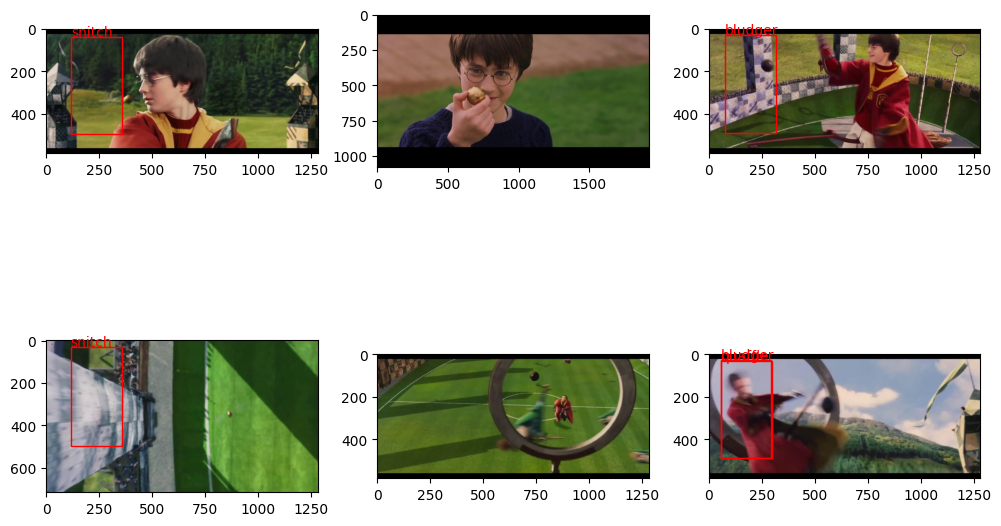

In [116]:
nl = ('/content/valid/images/74.jpg', '/content/valid/images/272.jpg', '/content/valid/images/23.jpg', '/content/valid/images/184.jpg', '/content/valid/images/26.jpg', '/content/valid/images/111.jpg')
visualisation(nl)